![logo](https://climate.copernicus.eu/sites/default/files/2025-03/logoline_c3s.png)

# Exploring precipitation information in the GIRAFE dataset

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.** 

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-sat-obs-atmos-physics/develop?labpath=precipitation-girafe.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-atmos-physics/blob/develop/precipitation-girafe.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-sat-obs-atmos-physics/blob/develop/precipitation-girafe.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-atmos-physics/blob/develop/precipitation-girafe.ipynb)

## Learning objectives 🎯

This notebook-tutorial provides an introduction to the use of the Global Interpolated RAinFall Estimation ([GIRAFE](https://cds.climate.copernicus.eu/datasets/satellite-precipitation-microwave-infrared?tab=overview)) data record for climate studies.

The Precipitation (PRE) Essential Climate Variable (ECV) and the GIRAFE product are described below. Then, a first use case provides an analysis of the time averaged global and seasonal climatological distributions of the Precipitation field as well as the monthly mean climatology. The second use case presents the time series and trend analysis of Precipitation. Step-by-step instructions are provided on data preparation; the use cases are extensively documented and each line of code is explained.

The three figures below show some results from the use cases and illustrate the successful run of the code.

![banner](./img/girafe-banner.png)

Anthropogenic activities and natural variations from years to decades shape the Earth's climate. Water and energy cycles are central to the physics of climate change. Within the hydrological cycle, precipitation has been recognised as an Essential Climate Variable (ECV) as it is the main component of water transport from the atmosphere to the Earth’s surface. Precipitation varies strongly, depending on geographical location, season, synopsis, and other meteorological factors. The supply with freshwater through precipitation is vital for many subsystems of the climate and the environment, but there are also hazards related to extensive precipitation (floods) or to the lack of precipitation (droughts).

## Prepare your environment

### Set up CDSAPI and your credentials

The code below will ensure that the `earthkit` package is installed. If you have not setup your `~/.cdsapirc` file with your credentials, you will be prompted to provide them when you request data from the CDS. You can find the credentials required on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [1]:
!pip install -q earthkit

### (Install and) Import libraries

The data have been stored in files written in NetCDF format. We will use [`earthkit-data`](https://earthkit-data.readthedocs.io) to download the data from the CDS, and open them with [`xarray`](http://xarray.pydata.org/en/stable/). `earthkit-data` will handle the specifics of the file and download formats, so you can focus on inspecting the data contents.

We will also be using [`earthkit-plots`](https://earthkit-plots.readthedocs.io), [`Matplotlib`](https://matplotlib.org/stable/index.html) and [`Cartopy`](https://scitools.org.uk/cartopy/docs/latest/) to visualise the data and [`statsmodels`](https://www.statsmodels.org/stable/index.html) for some advanced data manipulation.


In [2]:
import os

# Import the earthkit data and plots libraries
import earthkit.plots as ekp
import earthkit.data as ekd

# # Libraries for working with multidimensional arrays
import xarray as xr
import numpy as np
import pandas as pd

# Import a sublibrary method for the seasonal decomposition of the time series
from statsmodels.tsa.seasonal import seasonal_decompose

# Libraries for plotting and visualising the data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Explore the data

In the Copernicus Climate Data Store (CDS), the EUMETSAT Satellite Application Facility on Climate Monitoring has brokered the Global Interpolated RAinFall Estimation (GIRAFE) product. It merges microwave (MW) sounder- and imager-based estimations of instantaneous surface precipitation (over land and ocean) with infrared (IR) observations from geostationary platforms along the equator. GIRAFE is a global 1° x 1° latitude-longitude data record that is produced at a daily temporal resolution, as well as on a monthly mean basis. It covers the time period January 2002 to December 2022.

In this Jupyter notebook tutorial, we present examples, based on monthly mean Precipitation products, to illustrate the philosophy on the usage, visualisation, and analysis of the dataset. First you get to sort out data access and retrieval, and get all the right libraries in place for the computations. Then we take you through a short process of inspecting the retrieved data to see if it's all ok for analysis. You then have a chance to visualise your data, before we take you through some climatology analyses that you could use in your work.

You will find further information about the dataset (Algorithm Theoretical Basis Document, Product User Guide and Specification, etc.) as well as the data in the Climate Data Store catalogue entry ***Monthly and daily global interpolated rainfall estimation data from 2002 to 2022 derived from satellite measurements*** (see the link to the entry below), sections "[Overview](https://cds.climate.copernicus.eu/datasets/satellite-precipitation-microwave-infrared?tab=overview)", "[Download data](https://cds.climate.copernicus.eu/datasets/satellite-precipitation-microwave-infrared?tab=download)" and "[Documentation](https://cds.climate.copernicus.eu/datasets/satellite-precipitation-microwave-infrared?tab=documentation)":
- [Monthly and daily global interpolated rainfall estimation data from 2002 to 2022 derived from satellite measurements](https://cds.climate.copernicus.eu/datasets/satellite-precipitation-microwave-infrared?tab=overview)

### Search for data

To search for data, we will visit the CDS website: https://cds.climate.copernicus.eu/.
Here we can search for GIRAFE data using the search bar. The data we need for this use case is the [Monthly and daily global interpolated rainfall estimation data from 2002 to 2022 derived from satellite measurements](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-precipitation?tab=overview) dataset.
This catalogue entry provides daily and monthly accumulated precipitation amounts derived from the combination of MW imager and sounder retrievals over land and ocean surfaces with geostationary IR observations.

After selecting the correct catalogue entry, we will specify the time aggregation and temporal coverage we are interested in.
These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

:::{dropdown} Parameter of data to download

- Time aggregation: `Monthly`
- Year: `all` (use **"Select all"** button)
- Month: `all` (use **"Select all"** button)
- Day: `01` (or simply use **"Select all"** button)

:::

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below)

::: {warning}

Please remember to accept the terms and conditions of the dataset, at the bottom of the CDS download form!

:::

### Download data

Having copied the API request into the cell below, running this will retrieve and download the data we requested into our local directory. However, before we run the cell below, the terms and conditions of this particular dataset need to have been accepted in the CDS. The option to view and accept these conditions is given at the end of the download form, just above the **“Show API request”** option.

In [4]:
# Request the data
dataset = 'satellite-precipitation-microwave-infrared'
request = {
    'time_aggregation': 'monthly',
    'year': ['%04d' % (year) for year in range(2002, 2023)],
    'month': ['%02d' % (month) for month in range(1, 13)],
    'day': ['01'],
    'variable': 'all'
}
ek_ds = ekd.from_source(
    'cds',
    dataset,
    request,
)

2025-09-15 11:11:18,974 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-15 11:11:19,217 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-15 11:11:19,417 INFO Request ID is 977999e5-fc39-4794-b93f-82d593fa6574
2025-09-15 11:11:19,498 INFO status has been updated to accepted
2025-09-15 11:11:33,378 INFO status has been updated to running
2025-09-15 11:14:12,810 INFO status has been updated to successful


95952fa3245edbfa9fbf645c22df1f6e.zip:   0%|          | 0.00/103M [00:00<?, ?B/s]

  0%|          | 0/252 [00:00<?, ?it/s]

### Inspect data

The data have been downloaded to you `earthkit` cache, we can now use `earthkit` to open this in `xarray`. Behind the scenes, `earthkit` is unpacking a zip file which contains many netCDF files and then opening lazily with xarray. "Lazily" means that you do not load all the data into RAM and it is therefore safer to process on your computer.

The output of the cell below shows the `xarray.Dataset` representation of the downloaded data. The dataset has ten variables among which **precipitation**, and three dimension coordinates of **time**, **lat** and **lon**.

In [5]:
# Open the ek_ds as an xarray Dataset
ds_girafe = ek_ds.to_xarray()
ds_girafe

<xarray.Dataset> Size: 655MB
Dimensions:           (time: 252, nv: 2, lat: 180, lon: 360)
Coordinates:
  * time              (time) datetime64[ns] 2kB 2002-01-01 ... 2022-12-01
  * lat               (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon               (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds         (time, nv) datetime64[ns] 4kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds          (time, lat, nv) float64 726kB dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
    lon_bnds          (time, lon, nv) float64 1MB dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    record_status     (time) int8 252B dask.array<chunksize=(1,), meta=np.ndarray>
    precipitation     (time, lat, lon) float32 65MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    num_obs_fraction  (time, lat, lon) float64 131MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    num_obs_rate      (time, lat, lon) float64 131MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    num_days          (time, lat, lon) float64 131MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    quality_flag      (time, lat, lon) float32 65MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    num_days_snow     (time, lat, lon) float64 131MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/32)
    title:                      Global Interpolated RAinFall Estimation (GIRAFE)
    summary:                    This file contains data from the Precipitatio...
    id:                         DOI:10.5676/EUM_SAF_CM/GIRAFE/V001
    product_version:            1.0
    creator_name:               DE/DWD
    creator_email:              contact.cmsaf@dwd.de
    ...                         ...
    platform_vocabulary:        GCMD Platforms, Version 16.5
    instrument:                 SSM/I > Special Sensor Microwave/Imager,TMI >...
    instrument_vocabulary:      GCMD Instruments, Version 16.5
    variable_id:                precipitation
    CMSAF_processor:            girafe-app-v1.5.5
    license:                    The CM SAF data are owned by EUMETSAT and are...

While an `xarray.Dataset` may contain multiple variables, an Xarray `xarray.DataArray` holds a single multi-dimensional variable and its coordinates. The cell below extracts the **precipitation** data into an `xarray.DataArray` to make the processing easier.

The `xarray.DataArray` representation below displays the variable metadata, and also provides a graphical representation of the "[chunks](https://docs.dask.org/en/latest/array-chunks.html)" used the read the data, i.e. the quanta of data that are read.

In [6]:
da_precip = ds_girafe['precipitation']
da_precip

<xarray.DataArray 'precipitation' (time: 252, lat: 180, lon: 360)> Size: 65MB
dask.array<concatenate, shape=(252, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-01-01 2002-02-01 ... 2022-12-01
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  lwe_thickness_of_precipitation_amount
    cell_method:    time: mean
    units:          mm
    long_name:      monthly mean of daily accumulated precipitation

#### Plot the first time step

For a quick demonstration, we will use earthkit plots to produce a map of the first time step in the file. We are just using the `quickplot` method, without of the box settings.

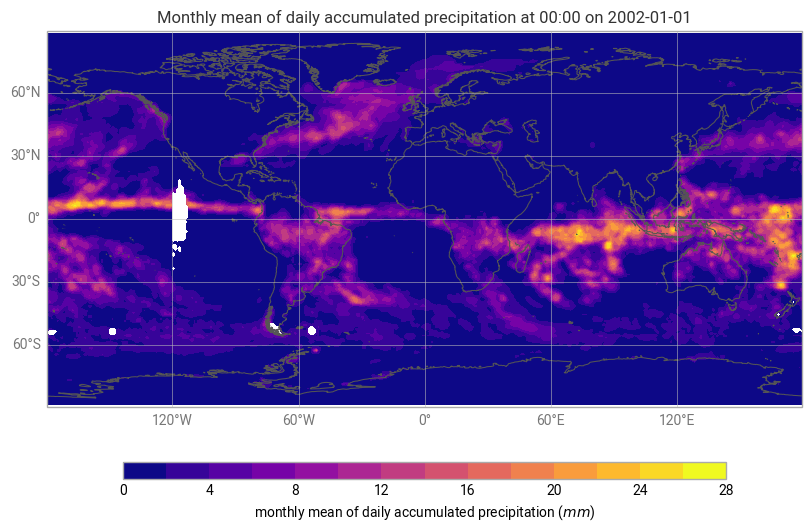

In [7]:
ekp.quickplot(da_precip.isel(time=0))

## Climatology of precipitations

In this section we will analyse the time averaged global and seasonal climatological distributions of GIRAFE precipitation as well as the monthly mean climatology.

### Time averaged global climatological distribution of precipitations

Let us calculate the mean climatology of precipitations for the time period January 2002 to December 2022.

First we have to select the specific time range by using the `xarray.sel` method which indexes the data and dimensions by the appropriate indexers.
Then, we apply the method `mean` to calculate the mean along the time dimension.

In [8]:
# Select the precip data for the whole time period
precip = da_precip.sel(time=slice('2002-01-01', '2022-12-31'))

# Calculate the mean along the time dimension
precip_mean = precip.mean(dim='time').assign_attrs(da_precip.attrs)
precip_mean

<xarray.DataArray 'precipitation' (lat: 180, lon: 360)> Size: 259kB
dask.array<mean_agg-aggregate, shape=(180, 360), dtype=float32, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  lwe_thickness_of_precipitation_amount
    cell_method:    time: mean
    units:          mm
    long_name:      monthly mean of daily accumulated precipitation

We can now visualize the global mean climatological distribution of precipitations for the period January 2002 - December 2022. 

This time, we will use some of the advanced `earthkit-plots` options and projection information from [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) to create a better quality figure. 

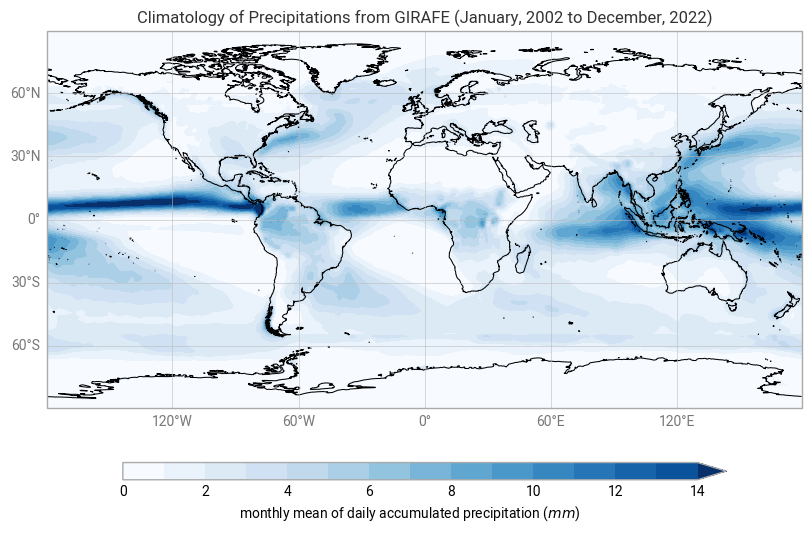

In [9]:
# Create the figure panel and the map using the Cartopy PlateCarree projection
chart = ekp.Map(crs=ccrs.PlateCarree())

# Define the style for the plot
precip_style = ekp.styles.Style(
    colors="Blues",
    levels=range(15),
    units="mm",
    extend="max",
)
chart.quickplot(precip_mean, style=precip_style)

chart.title(
    'Climatology of Precipitations from GIRAFE (January, 2002 to December, 2022)'
)
chart.coastlines(color='black')
chart.gridlines()

chart.legend()

chart.show()

**Figure 1** shows the global climatological distribution of precipitations for the time period of January 2002 - December 2022 over ocean and land.

The global climatological field of precipitations has a dominant structure along the equator, over water masses and rainforests like Amazonia. Most of the evaporation or evapotranspiration takes place in the tropics. Indeed, Solar irradiance and its relative position on the Earth's surface (solar zenith angle) controls evaporation, leading to the transition of water from the liquid phase to the gaseous phase, which is subsequently advected to higher altitudes and then condensated into precipitations. This mechanism is the main driver of the Inter-Tropical Convergence Zone (ITCZ) along the equator.


There are also moderately high values of daily accumulated precipitation amounts in the region of the Gulf Stream extension and the Kuroshio, the East of Japan, in association with the storm track regions.

### Time averaged seasonal climatological distribution of precipitations

Now, let us have a look at the seasonal climatological distribution of GIRAFE precipitations. <br>
For this purpose, we will use the `groupby()` method, with `'time.season'` as an argument, to split the data according to the seasons, and then average them over the years. <br>
Seasons are defined as follows:
- NH spring: March, April, May
- NH summer: June, July, August
- NH autumn: September, October, November
- NH winter: December, January, February

In [10]:
# Split data array precip by season
precip_seasonal_climatology = precip.groupby('time.season').mean('time')

# Assign season names to the coordinates
precip_seasonal_climatology = precip_seasonal_climatology.assign_coords({"season": ["Winter", "Spring", "Summer", "Autumn"]})

precip_seasonal_climatology

<xarray.DataArray 'precipitation' (season: 4, lat: 180, lon: 360)> Size: 1MB
dask.array<stack, shape=(4, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * season   (season) <U6 96B 'Winter' 'Spring' 'Summer' 'Autumn'
Attributes:
    standard_name:  lwe_thickness_of_precipitation_amount
    cell_method:    time: mean
    units:          mm
    long_name:      monthly mean of daily accumulated precipitation

The xarray `DataArray` **"precip_seasonal_climatology"** has four entries in the time dimension (one for each season). The climatological distribution of precipitations can now be plotted for each season.

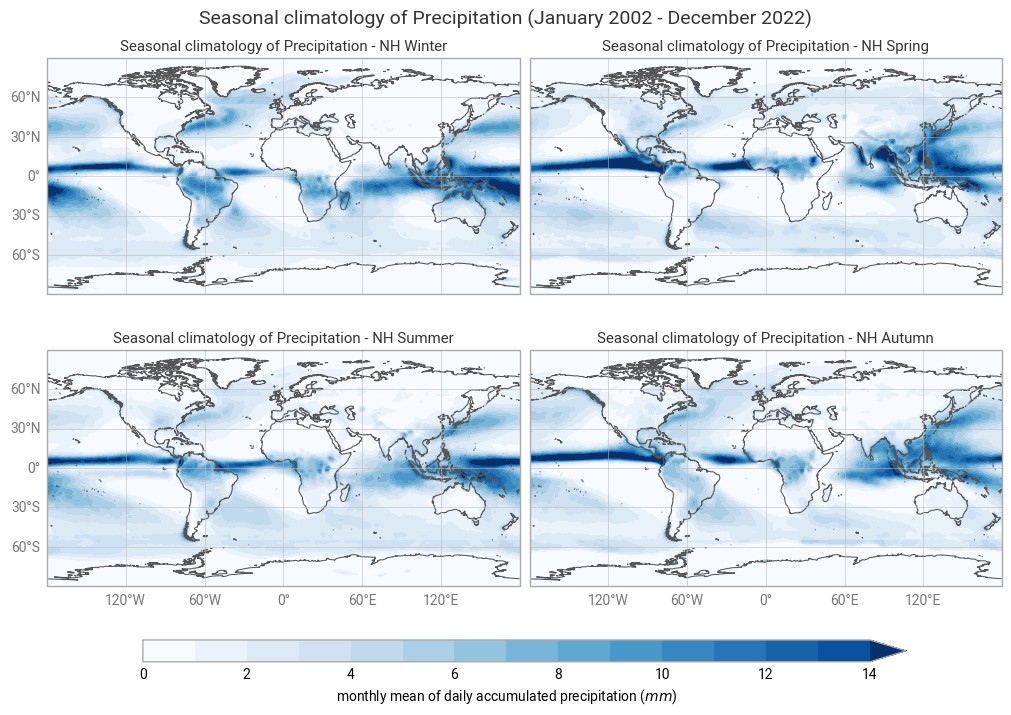

In [11]:
figure = ekp.Figure(crs=ccrs.PlateCarree(), rows=2, columns=2, size=(10, 7))

for i in range(2):
    for j in range(2):
        figure.add_map(i, j)

figure.quickplot(precip_seasonal_climatology, style=precip_style)

figure.coastlines()
figure.gridlines()

figure.subplot_titles('Seasonal climatology of Precipitation - NH {season}')
figure.title(
    "Seasonal climatology of Precipitation (January 2002 - December 2022)"
)
figure.legend()
figure.show()

**Figure 2** shows the seasonal mean climatology of the precipitation field from Northern Hemisphere spring to winter (top left to bottom right panels) derived from GIRAFE.

The general pattern is overall the same as in **Figure 1** with higher values in the tropics and lower values in the extra tropics. The band of high amount of precipitations (particularly noticeable between South-East Asia and North Australia) oscillates around the equator, reaching its highest values in the Summer Hemisphere, which confirms the dominant influence of the solar radiation over the course of the inter-tropical convergence zone.

### Zonally averaged montly mean climatology of precipitations

Let us now calculate the zonally averaged monthly mean climatology of precipitations over the time period January 2002 - December 2022, and visualise it in the form of a Hovmöller diagram. <br> 
A Hovmöller diagram is a common way of plotting meteorological or climatological data to depict their changes over time as a function of latitude or longitude. In our case, time will be recorded along the abscissa and latitude along the ordinate.


First, we will apply the `groupby()` method to group the **"precip"** `DataArray` by month, and then we will compute the average for each monthly group and longitude band.


The resulting data array is the zonally averaged monthly mean climatology for GIRAFE precipitations based on reference January 2002 - December 2022.

In [12]:
precip_clim_month = precip.groupby('time.month').mean("time")
precip_clim_month

<xarray.DataArray 'precipitation' (month: 12, lat: 180, lon: 360)> Size: 3MB
dask.array<stack, shape=(12, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  lwe_thickness_of_precipitation_amount
    cell_method:    time: mean
    units:          mm
    long_name:      monthly mean of daily accumulated precipitation

Let us view the zonal monthly climatology of the precipitation field. To do this, we will average across the longitude bands with the `mean()` method, align the time dimension coordinate with the x axis and the lat dimension coordinate along the y axis using the method `transpose()`...

In [13]:
precip_zonal_clim_month = precip_clim_month.mean(dim="lon").transpose()
precip_zonal_clim_month

<xarray.DataArray 'precipitation' (lat: 180, month: 12)> Size: 9kB
dask.array<transpose, shape=(180, 12), dtype=float32, chunksize=(180, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

Now we can plot our data. Before we do this however, we define the min, max and step of contours that we will use in a contour plot.

In [14]:
vdiv = 0.1
vmin = 0
vmax = 20
clevs = np.arange(vmin, vmax, vdiv)

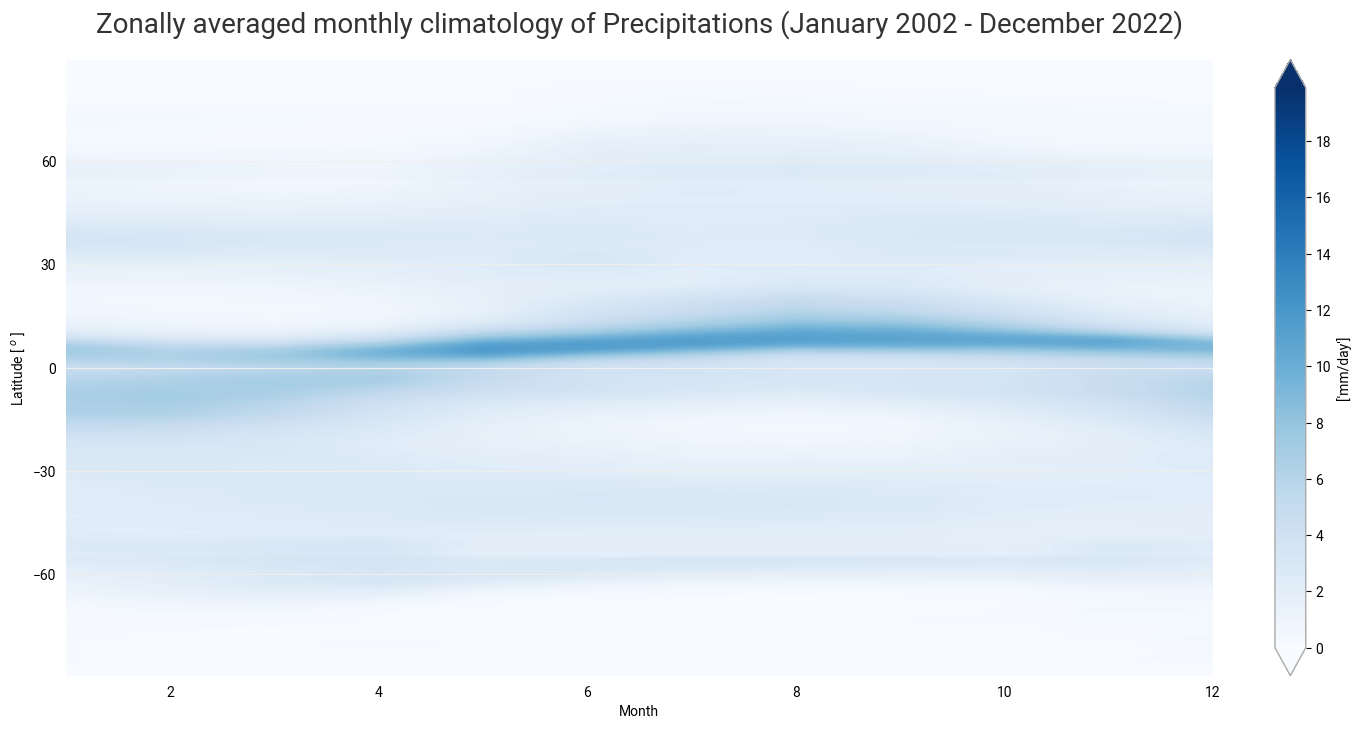

In [15]:
# Define the figure and specify size
fig3, ax3 = plt.subplots(1, 1, figsize=(16, 8))

# Configure the axes and figure title
ax3.set_xlabel('Month')
ax3.set_ylabel('Latitude [ $^o$ ]')
ax3.set_yticks(np.arange(-90, 91, 30))
ax3.set_title(
    'Zonally averaged monthly climatology of Precipitations (January 2002 - December 2022)',
    fontsize=20,
    pad=20)

# As the months (12) are much less than the latitudes (180),
# we need to ensure the plot fits into the size of the figure.
ax3.set_aspect('auto')

# Plot the data as a contour plot
contour = ax3.contourf(precip_zonal_clim_month.month,
                       precip_zonal_clim_month.lat,
                       precip_zonal_clim_month,
                       levels=clevs,
                       cmap='Blues',
                       extend='both')

# Specify the colorbar
cbar = plt.colorbar(contour, fraction=0.025, pad=0.05)
cbar.set_label(['mm/day'])
plt.show()

**Figure 3** shows the seasonal motion of the precipitation band crossing the equator from boreal summer to austral summer, associated with the ITCZ and the Rain Season.

In the next use case, we will analyse the temporal evolution of the precipitation amount and its annual seasonal variation.

## Time series and trend analysis of precipitations

After looking at the time averaged global distribution of precipitations, we further investigate the dataset. The GIRAFE product spans over 20 years of satellite observations, and another useful way of analysing and visualizing the temporal evolution of rainfall accumulated precipitation amounts is using the time series. We will calculate global time series, plot it, and discuss most important features.

### Global time series of precipitations

We first create a temporal subset for the period January 2002 to December 2021.

In [16]:
# Select time period
precip_girafe = da_precip.sel(time=slice('2002-01-01', '2022-12-31'))
precip_girafe

<xarray.DataArray 'precipitation' (time: 252, lat: 180, lon: 360)> Size: 65MB
dask.array<concatenate, shape=(252, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-01-01 2002-02-01 ... 2022-12-01
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  lwe_thickness_of_precipitation_amount
    cell_method:    time: mean
    units:          mm
    long_name:      monthly mean of daily accumulated precipitation

#### Spatial aggregation

We would like to visualise these data, not in maps but as one dimensional time series of global average values. To do this, we will first need to aggregate the data spatially to create a single global average at each time step. In order to aggregate over the latitudinal dimension, we need to take into account the variation in area as a function of latitude. We will do this by using the cosine of the latitude as a proxy:

In [17]:
weights = np.cos(np.deg2rad(precip_girafe.lat))
weights.name = "weights"
precip_girafe_weighted = precip_girafe.weighted(weights)

The next step is to compute the mean across the latitude and longitude dimensions of the weighted data array with the `mean()` method.

In [18]:
precip_weighted_mean = precip_girafe_weighted.mean(dim=("lat", "lon"))

#### Plot data

Now we can plot the time series of globally averaged GIRAFE precipitation data over time using the `plot()` method.


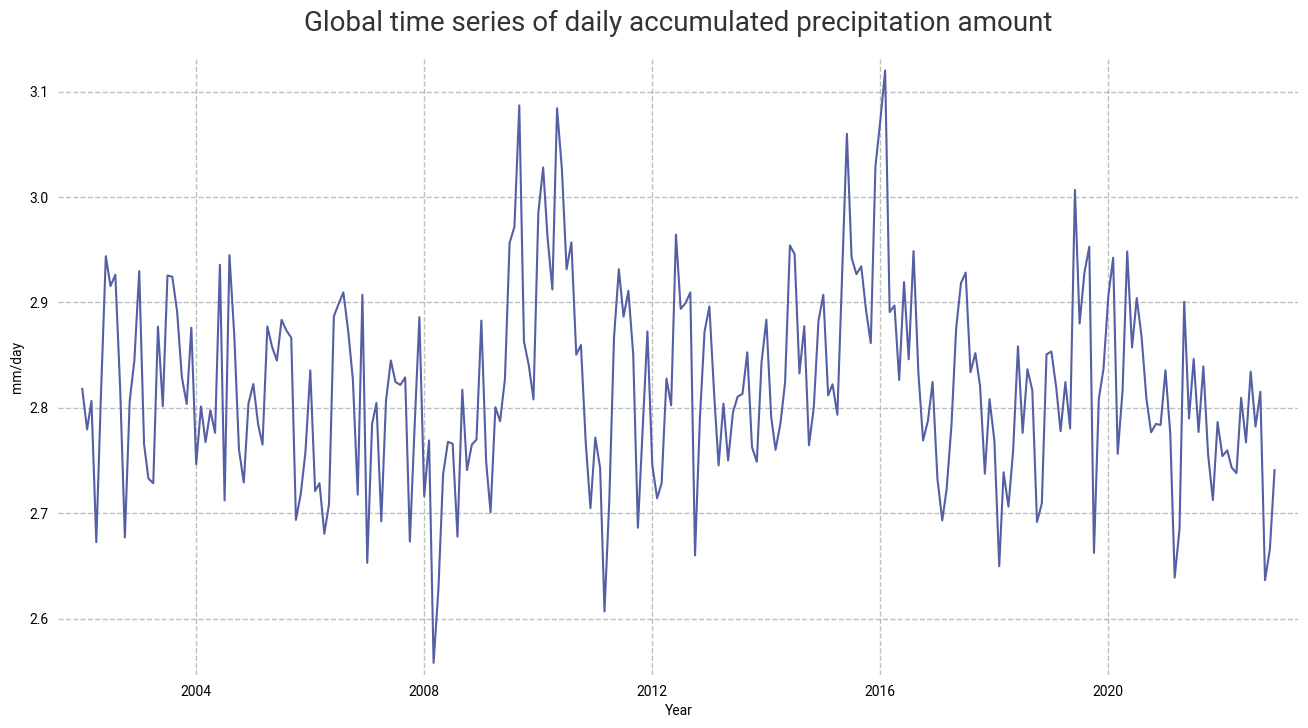

In [19]:
# Define the figure and specify size
fig4, ax4 = plt.subplots(1, 1, figsize=(16, 8))

# Configure the axes and figure title
ax4.set_xlabel('Year')
ax4.set_ylabel('mm/day')
ax4.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax4.set_title('Global time series of daily accumulated precipitation amount', fontsize=20, pad=20)

# Plot the data
ax4.plot(precip_weighted_mean.time, precip_weighted_mean)

plt.show()

**Figure 4** shows the time series of the daily accumulated precipitation amount. From the time series, we can infer the seasonal pattern along with a (decreasing) trend in the global space and time averaged global interpolated rainfall estimation.

We will now procede to the seasonal decomposition of the total column water vapour to study this trend in more details.

### Trend analysis and seasonal cycle of precipitation

The time series can be further analysed by extracting the trend, or the running annual mean, and the seasonal cycle.

To this end, we will convert the Xarray `DataArray` into a time series with the [pandas](https://pandas.pydata.org/) library. Then we will decompose it into the trend, the seasonal cycle and the residuals by using the `seasonal_decompose()` method. Finally, we will visualize the results.

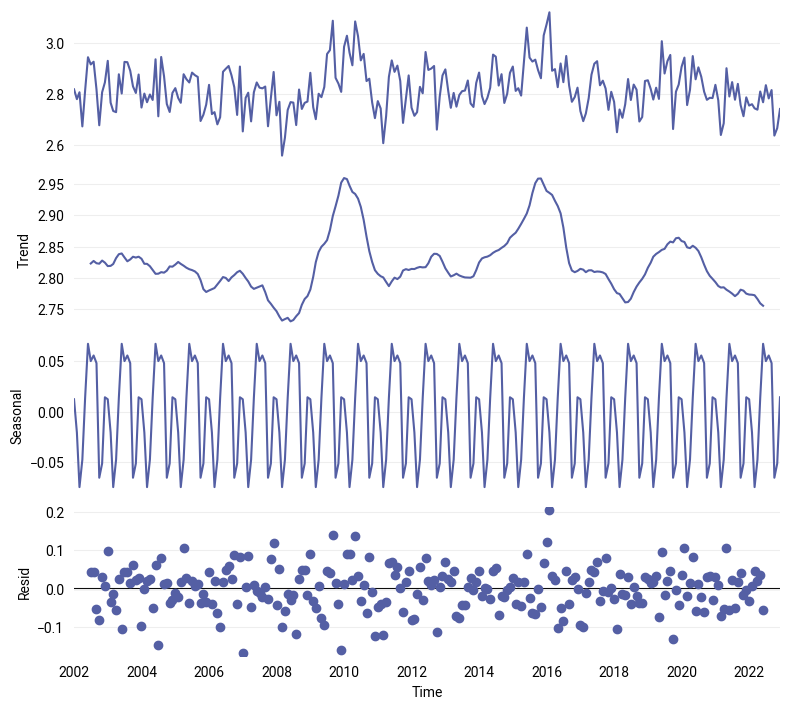

In [20]:
# Convert the Xarray data array precip_weighted_mean into a time series
precip_weighted_mean_series = pd.Series(precip_weighted_mean)
# Define the time dimension of tcwv_weighted_mean as the index of the time series
precip_weighted_mean_series.index = precip_weighted_mean.time.to_dataframe().index

# Decomposition of the time series into the trend, the seasonal cycle and the residuals
precip_seasonal_decomposition = seasonal_decompose(precip_weighted_mean_series,
                                                   model='additive',
                                                   period=12)

# Plot the resulting seasonal decomposition
precip_seasonal_decomposition.plot()
plt.xlabel("Time")
plt.show()

**Figure 5** shows the decomposition of the GIRAFE daily accumulated precipitation time series into the trend (2nd panel) and the seasonal cycle (3rd panel), from which are derived the anomalies or de-trended and de-seasonalised time series that have the characteristics of uncorrelated noise pattern (4th panel).

The trend analysis presents two peaks around the years 2010 and 2016, which can be related respectively to a moderate “El Niño” event in 2009-10 and a strong one in 2015-16. The combination of strong “El Niño” events and higher overall trends might lead to extremes in the precipitation amount in the future, and the decreasing trend shall be further examined too.

### Regional time series and trend analysis

We can also use the GIRAFE dataset to visualise and analyse the temporal evolution of precipitations over some regions of interest that have a specific regime, like, for example, the Amazon rainforest in Brasil, the semi-arid region of Sahel in Africa, India for Monsoon, or Indonesia that is located in the Warm Pool.


For this purpose, we will re-use the code from the previous section, but we will need to add one additional step: select the corresponding regions by their repective coordinates from the original global dataset.

In [21]:
# Select the specific regions
precip_amazon = precip_girafe.sel(lat=slice(-15, 0), lon=slice(-75, -60))
precip_sahel = precip_girafe.sel(lat=slice(10, 20), lon=slice(-15, 30))
precip_india = precip_girafe.sel(lat=slice(0, 30), lon=slice(60, 90))
precip_indonesia = precip_girafe.sel(lat=slice(-15, 15), lon=slice(90, 150))

# Spatial aggregation
# Apply weights
precip_amazon_weighted = precip_amazon.weighted(weights)
precip_sahel_weighted = precip_sahel.weighted(weights)
precip_india_weighted = precip_india.weighted(weights)
precip_indonesia_weighted = precip_indonesia.weighted(weights)
# Compute weighted mean
precip_amazon_wmean = precip_amazon_weighted.mean(dim=('lat', 'lon'))
precip_sahel_wmean = precip_sahel_weighted.mean(dim=('lat', 'lon'))
precip_india_wmean = precip_india_weighted.mean(dim=('lat', 'lon'))
precip_indonesia_wmean = precip_indonesia_weighted.mean(dim=('lat', 'lon'))

This time, to analyse and visualise the trend over the time period of the GIRAFE dataset, we will compute the running annual mean by using the `rolling` method for each region.

In [22]:
# Compute the rolling mean for each region
precip_amazon_rmean = precip_amazon_wmean.rolling(time=12, center=True).mean()
precip_sahel_rmean = precip_sahel_wmean.rolling(time=12, center=True).mean()
precip_india_rmean = precip_india_wmean.rolling(time=12, center=True).mean()
precip_indonesia_rmean = precip_indonesia_wmean.rolling(time=12, center=True).mean()

# Creation of a dataset with the rolling mean for each region
precip_region_rmean = xr.Dataset(data_vars=dict(BRZL=precip_amazon_rmean,
                                                SAHEL=precip_sahel_rmean,
                                                IND=precip_india_rmean,
                                                IDSA=precip_indonesia_rmean
                                               ),
                                 coords=dict(time=precip_amazon_rmean.time),
                                )

We can now plot the resulting time series of precipitation for each region.

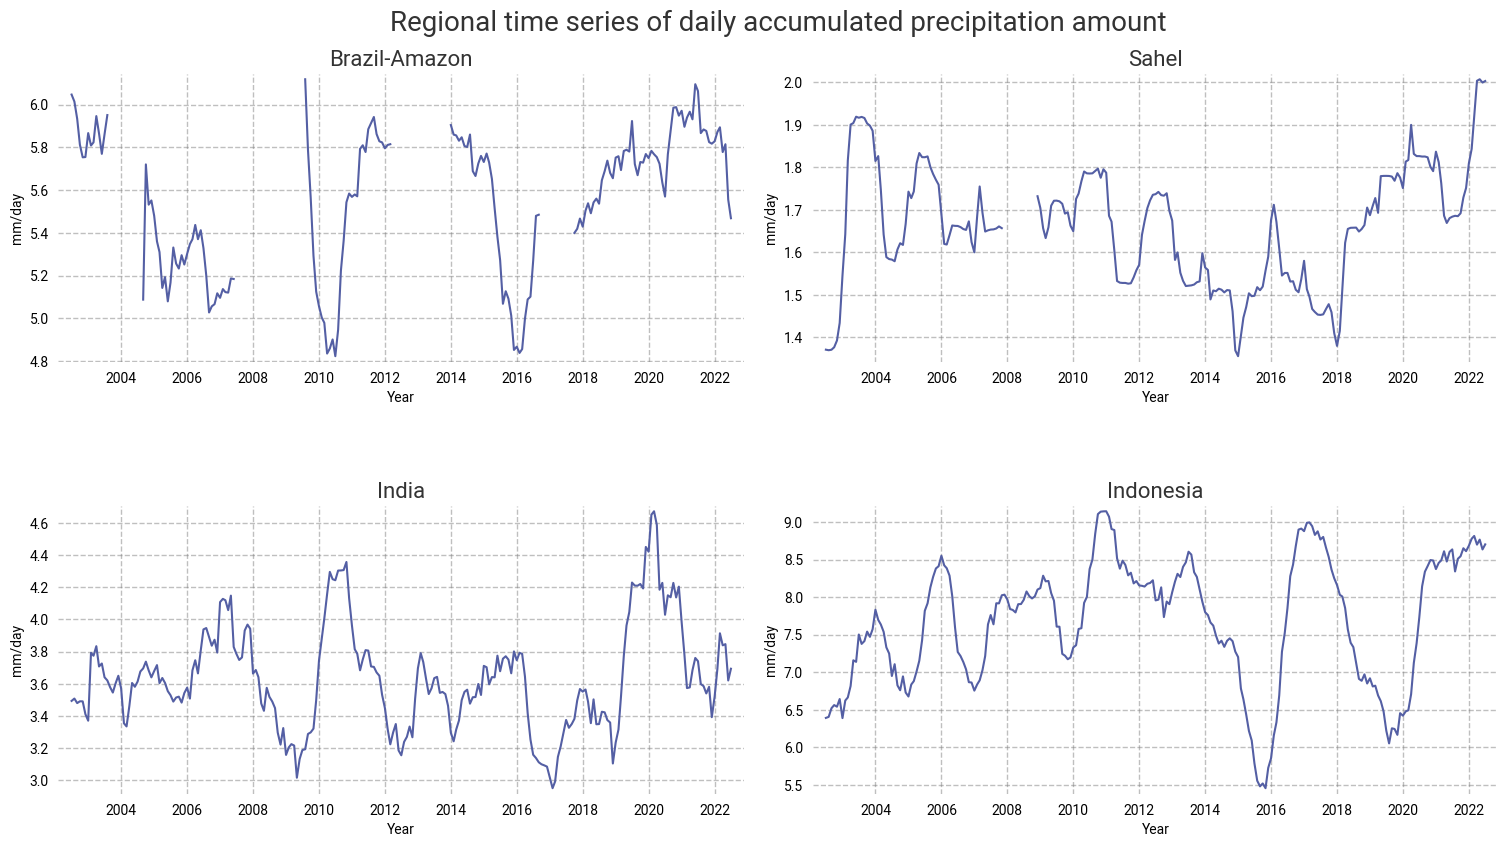

In [23]:
# Create a list of the regions of interest:
regions = ['BRZL', 'SAHEL', 'IND', 'IDSA']

# We use the "subplots" to place multiple plots according to our needs. 
# In this case, we want 4 plots in a 2x2 format.
# For this "nrows" = 2 and "ncols" = 2, the projection and size are defined as well
fig5, ax5 = plt.subplots(nrows=2,
                         ncols=2,
                         figsize=(16,8))

# Define a dictionary of subtitles, each one corresponding to a season
subtitles = {'BRZL': 'Brazil-Amazon', 'SAHEL': 'Sahel', 'IND': 'India', 'IDSA': 'Indonesia'}

# Configure the axes and subplot titles
for i_region, c_region in enumerate(regions):
    # convert i_season index into (row, col) index
    row = i_region // 2
    col = i_region % 2
    ax5[row][col].set_xlabel('Year')
    ax5[row][col].set_ylabel('mm/day')
    ax5[row][col].grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax5[row][col].set_title(subtitles[c_region], fontsize=16)
    # Plot the data
    ax5[row][col].plot(precip_region_rmean.time, precip_region_rmean[c_region])
    
# Place the subplots
fig5.subplots_adjust(bottom=0.0, top=0.9, left=0.05, right=0.95, wspace=0.1, hspace=0.5)

# Define an overall title
fig5.suptitle('Regional time series of daily accumulated precipitation amount',
              fontsize=20)

plt.show()

**Figure 6** shows the temporal evolution of precipitations over Brazil, Sahel, India and Indonesia for the time period 2002-2022. <br>
No trend can be infered in the precipitation amount in the Amazon rainforest due to the lack of months (and even years) of GIRAFE observations over this region of Brazil. <br>
Over Sahel, no significant trend is observed during the first decade of GIRAFE TCDR. Then, after a period of drought of ~4 years between 2014 and 2018, the amount of precipitation increases abruptly up until December 2022. <br>
In the last decade, extreme values of precipitation that could lead to droughts or floods tend to increase over India or Indonesia (especially).

## Take home messages 📌

- Use cases to illustrate how the global interpolated rainfall estimation (GIRAFE) Precipitation product can be used to study, analyse and visualise this essential climate variable.
- The high values found along the equator can be explained by the Inter-Tropical Convergence Zone
- The moderately high values observed in the region of the Gulf Stream extension and Kurushio are associated to the storm track regions. 
- Comparisons with other independent datasets to further investigate trends (like more frequent episodes of floods and droughts) that can be attributed to global climate change, El-Niño events, etc.